This IPython Notebook introduces the use of the `openmc.kinetics` module to perform a transient simulation on an infinite homogeneous medium. In particular, this Notebook introduces the the following features:

* Initialization of the openmc.kinetics solver for an **infinite homogeneous medium**
* Executing the initial calculation to compute the initial reactor state.
* Extracting the cross sections at the initial state.
* Computation of the initial delayed neutron precursor concentrations.
* Normalization of the flux and precursor concentrations to an initial power level.
* Computation of the point kinetics parameters.

**Note:** This Notebook illustrates the use of [Pandas](http://pandas.pydata.org/) `DataFrames` to containerize multi-group cross section data. We recommend using [Pandas](http://pandas.pydata.org/) >v0.15.0 or later since OpenMC's Python API leverages the multi-indexing feature included in the most recent releases of [Pandas](http://pandas.pydata.org/).

## Introduction to Kinetics (openmc.kinetics)

Many Monte Carlo particle transport codes, including OpenMC, compute fixed source and eigenvalue solutions to the neutron flux in a reactor. However, many problems are time dependent and users have in interest in explicitly modeling the change of the reactor over time. Often the reactor is condensed down to a OD point, and the kinetic equations are propagated forward using the "point kinetic equations". In this notebook, we show how to set up a kinetics problem in OpenMC and compute the initial point kinetic parameters.

The `openmc.kinetics` Python module is designed to leverage OpenMC's tally system to calculate the necessary multi-group cross sections and parameters with arbitrary energy group structures and spatial meshes for low-order operator transient neutron transport applications.

Before proceeding to illustrate how one may use the `openmc.kinetics` module, it is worthwhile to define the general equations used to calculate kinetics parameters. This is only intended as a brief overview of the methodology used by `openmc.kinetics` - we refer the interested reader to the large body of literature on the subject for a more comprehensive understanding of this complex topic.

### Introductory Notation
The continuous real-valued microscopic cross section may be denoted $\sigma_{n,x}(\mathbf{r}, E)$ for position vector $\mathbf{r}$, energy $E$, nuclide $n$ and interaction type $x$. Similarly, the scalar neutron flux may be denoted by $\Phi(\mathbf{r},E)$ for position $\mathbf{r}$ and energy $E$. **Note**: Although nuclear cross sections are dependent on the temperature $T$ of the interacting medium, the temperature variable is neglected here for brevity.

### Spatial and Energy Discretization
The energy domain for critical systems such as thermal reactors spans more than 10 orders of magnitude of neutron energies from 10$^{-5}$ - 10$^7$ eV. The multi-group approximation discretization divides this energy range into one or more energy groups. In particular, for $G$ total groups, we denote an energy group index $g$ such that $g \in \{1, 2, ..., G\}$. The energy group indices are defined such that the smaller group the higher the energy, and vice versa. The integration over neutron energies across a discrete energy group is commonly referred to as **energy condensation**.

The delayed neutrons created from fissions are created from > 30 delayed neutron precursors. Modeling each of the delayed neutron precursors is possible, but this approach has not recieved much attention due to large uncertainties in certain precursors. Therefore, the delayed neutrons are often combined into "delayed groups" that have a set time constant, $\lambda_d$. Some cross section libraries use the same group time constants for all nuclides (e.g. JEFF 3.1) while other libraries use different time constants for all nuclides (e.g. ENDF/B-VII.1). Multi-delayed-group cross sections can either be created with the entire delayed group set, a subset of delayed groups, or integrated over all delayed groups.

Multi-group cross sections are computed for discretized spatial zones in the geometry of interest. The spatial zones may be defined on a structured and regular fuel assembly or pin cell mesh, an arbitrary unstructured mesh or the constructive solid geometry used by OpenMC. For a geometry with $K$ distinct spatial zones, we designate each spatial zone an index $k$ such that $k \in \{1, 2, ..., K\}$. The volume of each spatial zone is denoted by $V_{k}$. The integration over discrete spatial zones is commonly referred to as **spatial homogenization**.

### General Scalar-Flux Weighted MDGXS
The multi-group cross sections computed by `openmc.mgxs` are defined as a *scalar flux-weighted average* of the microscopic cross sections across each discrete energy group. This formulation is employed in order to preserve the reaction rates within each energy group and spatial zone. In particular, spatial homogenization and energy condensation are used to compute the general multi-group cross section. For instance, the delayed-nu-fission multi-energy-group and multi-delayed-group cross section, $\nu_d \sigma_{f,x,k,g}$, can be computed as follows:

$$\nu_d \sigma_{n,x,k,g} = \frac{\int_{E_{g}}^{E_{g-1}}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r} \nu_d \sigma_{f,x}(\mathbf{r},E')\Phi(\mathbf{r},E')}{\int_{E_{g}}^{E_{g-1}}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r}\Phi(\mathbf{r},E')}$$

This scalar flux-weighted average microscopic cross section is computed by `openmc.mgxs` for only the delayed-nu-fission and delayed neutron fraction reaction type at the moment. These double integrals are stochastically computed with OpenMC's tally system - in particular, [filters](https://mit-crpg.github.io/openmc/pythonapi/filter.html) on the energy range and spatial zone (material, cell, universe, or mesh) define the bounds of integration for both numerator and denominator.

### Multi-Group Prompt and Delayed Fission Spectrum
The energy spectrum of neutrons emitted from fission is denoted by $\chi_{n}(\mathbf{r},E' \rightarrow E'')$ for incoming and outgoing energies $E'$ and $E''$, respectively. Unlike the multi-group cross sections $\sigma_{n,x,k,g}$ considered up to this point, the fission spectrum is a probability distribution and must sum to unity. The outgoing energy is typically much less dependent on the incoming energy for fission than for scattering interactions. As a result, it is common practice to integrate over the incoming neutron energy when computing the multi-group fission spectrum. The fission spectrum may be simplified as $\chi_{n}(\mathbf{r},E)$ with outgoing energy $E$.

Computing the cumulative energy spectrum of emitted neutrons, $\chi_{n}(\mathbf{r},E)$, has been presented in the `mgxs-part-i.ipynb` notebook. Here, we will present the energy spectrum of prompt and delayed emission neutrons, $\chi_{n,p}(\mathbf{r},E)$ and $\chi_{n,d}(\mathbf{r},E)$, respectively. Unlike the multi-group cross sections defined up to this point, the multi-group fission spectrum is weighted by the fission production rate rather than the scalar flux. This formulation is intended to preserve the total fission production rate in the multi-group deterministic calculation. In order to mathematically define the multi-group fission spectrum, we denote the microscopic fission cross section as $\sigma_{n,f}(\mathbf{r},E)$ and the average number of neutrons emitted from fission interactions with nuclide $n$ as $\nu_{n,p}(\mathbf{r},E)$ and $\nu_{n,d}(\mathbf{r},E)$ for prompt and delayed neutrons, respectively. The multi-group fission spectrum $\chi_{n,k,g,d}$ is then the probability of fission neutrons emitted into energy group $g$ and delayed group $d$. There are not prompt groups, so inserting $p$ in place of $d$ just denotes all prompt neutrons. 

Similar to before, spatial homogenization and energy condensation are used to find the multi-energy-group and multi-delayed-group fission spectrum $\chi_{n,k,g,d}$ as follows:

$$\chi_{n,k,g',d} = \frac{\int_{E_{g'}}^{E_{g'-1}}\mathrm{d}E''\int_{0}^{\infty}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r}\chi_{n,d}(\mathbf{r},E'\rightarrow E'')\nu_{n,d}(\mathbf{r},E')\sigma_{n,f}(\mathbf{r},E')\Phi(\mathbf{r},E')}{\int_{0}^{\infty}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r}\nu_{n,d}(\mathbf{r},E')\sigma_{n,f}(\mathbf{r},E')\Phi(\mathbf{r},E')}$$

The fission production-weighted multi-energy-group and multi-delayed-group fission spectrum for delayed neutrons is computed using OpenMC tallies with energy in, energy out, and delayed group filters. Alternatively, the delayed group filter can be omitted to compute the fission spectrum integrated over all delayed groups.

This concludes our brief overview on the methodology to compute multi-energy-group and multi-delayed-group cross sections. The following sections detail more concretely how users may employ the `openmc.mgxs` module to power simulation workflows requiring multi-group cross sections for downstream deterministic calculations.

## Generate Input Files

In [1]:
from IPython.display import Image
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.sparse.linalg import spsolve

import openmc
import openmc.mgxs as mgxs
import openmc.kinetics as kinetics

First we need to define materials that will be used in the problem. Before defining a material, we must create nuclides that are used in the material.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H1')
o16 = openmc.Nuclide('O16')
u235 = openmc.Nuclide('U235')
u238 = openmc.Nuclide('U238')
pu239 = openmc.Nuclide('Pu239')
zr90 = openmc.Nuclide('Zr90')

With the nuclides we defined, we will now create a material for the homogeneous medium.

In [3]:
# Instantiate a Material and register the Nuclides
inf_medium = openmc.Material(name='moderator')
inf_medium.set_density('g/cc', 5.)
inf_medium.add_nuclide(h1,  0.03)
inf_medium.add_nuclide(o16, 0.015)
inf_medium.add_nuclide(u235 , 0.0001)
inf_medium.add_nuclide(u238 , 0.007)
inf_medium.add_nuclide(pu239, 0.00003)
inf_medium.add_nuclide(zr90, 0.002)

With our material, we can now create a `Materials` object that can be exported to an actual XML file.

In [4]:
# Instantiate a Materials collection and export to XML
materials_file = openmc.Materials([inf_medium])
materials_file.default_xs = '71c'

Now let's move on to the geometry. This problem will be a simple square cell with reflective boundary conditions to simulate an infinite homogeneous medium. The first step is to create the outer bounding surfaces of the problem.

In [5]:
# Instantiate boundary Planes
min_x = openmc.XPlane(boundary_type='vacuum', x0=-50.0)
max_x = openmc.XPlane(boundary_type='reflective', x0= 50.0)
min_y = openmc.YPlane(boundary_type='reflective', y0=-50.0)
max_y = openmc.YPlane(boundary_type='reflective', y0= 50.0)
min_z = openmc.ZPlane(boundary_type='reflective', z0=-50.0)
max_z = openmc.ZPlane(boundary_type='reflective', z0= 50.0)

With the surfaces defined, we can now create a cell that is defined by intersections of half-spaces created by the surfaces.

In [6]:
# Instantiate a Cell
cell = openmc.Cell(cell_id=1, name='cell')

# Register bounding Surfaces with the Cell
cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Fill the Cell with the Material
cell.fill = inf_medium

OpenMC requires that there is a "root" universe. Let us create a root universe and add our square cell to it.

In [7]:
# Instantiate Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(cell)

We now must create a geometry that is assigned a root universe and export it to XML.

In [8]:
# Create Geometry and set root Universe
openmc_geometry = openmc.Geometry()
openmc_geometry.root_universe = root_universe

Next, we must define simulation parameters. In this case, we will use 10 inactive batches and 40 active batches each with 2500 particles.

In [9]:
# OpenMC simulation parameters
batches = 50
inactive = 25
particles = 1000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-50.0, -50.0, -50.0, 50.0, 50.0, 50.0]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

Now we are ready to generate multi-group cross sections! First, let's define a 100-energy-group structure and 1-energy-group structure using the built-in `EnergyGroups` class. We will also create a 6-delayed-group list.

In [10]:
# Instantiate a 50-group EnergyGroups object
fine_groups = mgxs.EnergyGroups()
fine_groups.group_edges = np.logspace(-10,1.4,21)

# Instantiate a 2-group EnergyGroups object
energy_groups = mgxs.EnergyGroups()
energy_groups.group_edges = [fine_groups.group_edges[0],  fine_groups.group_edges[10], fine_groups.group_edges[-1]]

# Instantiate a 1-group EnergyGroups object
one_group = mgxs.EnergyGroups()
one_group.group_edges = [fine_groups.group_edges[0], fine_groups.group_edges[-1]]

We can now use the `EnergyGroups` object and delayed group list, along with our previously created materials and geometry, to create some `MGXS` libraries for the transient solve using the `openmc.kinetics` module. In particular, the kinetics module will create libraries with the following `MGXS`:

* `TotalXS`
* `TransportXS`
* `AbsorptionXS`
* `KappaFissionXS`
* `NuScatterMatrixXS`
* `NuScatterXS`
* `ChiPrompt`
* `InverseVelocity`
* `PromptNuFissionXS`
* `DelayedNuFissionXS`
* `NuFissionXS`
* `ChiDelayed`
* `Chi`
* `Beta`

These classes provide us with an interface to generate the tally inputs as well as perform post-processing of OpenMC's tally data to compute the respective multi-group cross sections. 

In [11]:
# Instantiate a mesh object
mesh = openmc.Mesh(mesh_id=1)
mesh.type = 'regular'
mesh.dimension = [2, 2, 1]
mesh.lower_left = bounds[:3]
mesh.width = [(bounds[3] - bounds[0])/mesh.dimension[0],
              (bounds[4] - bounds[1])/mesh.dimension[1],
              (bounds[5] - bounds[2])/mesh.dimension[2]]


# Instantiate a kinetics solver object
solver = openmc.kinetics.Solver()
solver.num_delayed_groups = 6
solver.mesh           = mesh
solver.one_group      = one_group
solver.energy_groups  = energy_groups
solver.fine_groups    = fine_groups
solver.geometry       = openmc_geometry
solver.settings_file  = settings_file
solver.materials_file = materials_file
solver.initialize_mgxs()

Each multi-group cross section object stores its tallies in a Python dictionary called `tallies`. We can inspect the tallies in the dictionary for our `Beta` object as follows. 

In [12]:
solver.mgxs_lib['START']['chi-delayed'].tallies

OrderedDict([('delayed-nu-fission-in', Tally
              	ID             =	10000
              	Name           =	START - chi-delayed
              	Filters        =	
                              		mesh	[1]
                              		energy	[  1.00000000e-10   2.51188643e+01]
              	Nuclides       =	total 
              	Scores         =	['delayed-nu-fission']
              	Estimator      =	analog), ('delayed-nu-fission-out', Tally
              	ID             =	10001
              	Name           =	START - chi-delayed
              	Filters        =	
                              		mesh	[1]
                              		energyout	[  1.00000000e-10   5.01187234e-05   2.51188643e+01]
              	Nuclides       =	total 
              	Scores         =	['delayed-nu-fission']
              	Estimator      =	analog)])

The `Beta` object includes tracklength tallies for the 'nu-fission' and 'delayed-nu-fission' scores in the 100-energy-group and 6-delayed-group structure in cell 1. Now that each `MGXS` and `MDGXS` object contains the tallies that it needs, we must add these tallies to a `Tallies` object to generate the "tallies.xml" input file for OpenMC.

Now we a have a complete set of inputs, so we can go ahead and run our simulation.

In [13]:
# Remove old HDF5 (summary, statepoint) files
!rm statepoint.*

# Run OpenMC
solver.run_openmc('START')


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

In [14]:
solver.compute_initial_flux()

linear solver iter 0 resid 9.04786e-03 k-eff 1.235155
linear solver iter 1 resid 8.65612e-03 k-eff 1.235122
linear solver iter 2 resid 8.28799e-03 k-eff 1.235090
linear solver iter 3 resid 7.94145e-03 k-eff 1.235059
linear solver iter 4 resid 7.61471e-03 k-eff 1.235028
linear solver iter 5 resid 7.30619e-03 k-eff 1.234999
linear solver iter 6 resid 7.01446e-03 k-eff 1.234970
linear solver iter 7 resid 6.73824e-03 k-eff 1.234942
linear solver iter 8 resid 6.47637e-03 k-eff 1.234914
linear solver iter 9 resid 6.22783e-03 k-eff 1.234888
linear solver iter 10 resid 5.99167e-03 k-eff 1.234862
linear solver iter 11 resid 5.76703e-03 k-eff 1.234837
linear solver iter 12 resid 5.55314e-03 k-eff 1.234812
linear solver iter 13 resid 5.34931e-03 k-eff 1.234788
linear solver iter 14 resid 5.15487e-03 k-eff 1.234765
linear solver iter 15 resid 4.96925e-03 k-eff 1.234743
linear solver iter 16 resid 4.79190e-03 k-eff 1.234721
linear solver iter 17 resid 4.62233e-03 k-eff 1.234699
linear solver iter 1

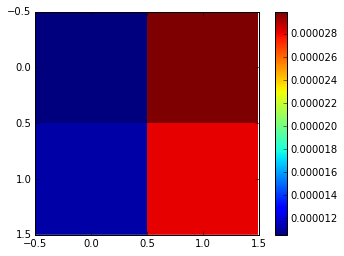

In [15]:
flux = np.copy(solver.flux['START'])
flux.shape = (mesh.dimension[0], mesh.dimension[1], mesh.dimension[2], energy_groups.num_groups)
flux_plane = flux[:,:,0,:]

plt.imshow(flux_plane[:,:,0],interpolation='none')
plt.colorbar()

OpenMC has generated all the cross sections we need. Now let's go about importing and inspecting them. First we will look at the diffusion coefficients. There are several different methods to compute the diffusion coefficients. In all cases, we first tally the total and transport cross sections on a fine energy mesh. Then we collapse either $\Sigma_T$, $\Sigma_{Tr}$, or $\frac{1}{3 \Sigma_{Tr}}$:

* **Flux-weighted total cross section**: Collapse $\Sigma_T$ and take the diffusion coefficient as $\frac{1}{3 \Sigma_T}$.
* **Flux-weighted transport cross section**: Collapse $\Sigma_{Tr}$ and take the diffusion coefficient as $\frac{1}{3 \Sigma_{Tr}}$.
* **Flux-weighted diffusion coefficient**: Collapse $\frac{1}{3 \Sigma_{Tr}}$. 

As we can see from the plot below, the approximation has a large impact on the diffusion coefficients. In future analysis, we will be using the **flux-weighted diffusion coefficient**.

(0, 4)

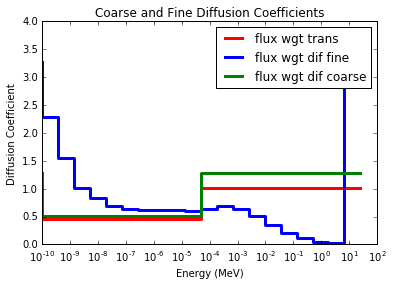

In [16]:
ng  = energy_groups.num_groups
nfg = fine_groups.num_groups

flux_wgt_trans  = 1.0 / (3.0 * solver.mgxs_lib['START']['transport'].get_xs().flatten())[range(ng)]
dif_coef_fine   = solver.mgxs_lib['START']['diffusion-coefficient'].get_xs().flatten()[range(nfg)]
dif_coef_coarse = solver.mgxs_lib['START']['diffusion-coefficient'].get_condensed_xs(energy_groups).get_xs().flatten()[range(ng)]

flux_wgt_trans = np.append(flux_wgt_trans, flux_wgt_trans[0])
dif_coef_fine = np.append(dif_coef_fine, dif_coef_fine[0])
dif_coef_coarse = np.append(dif_coef_coarse, dif_coef_coarse[0])

plt.figure()
plt.semilogx(energy_groups.group_edges, flux_wgt_trans, drawstyle='steps', color='r', linestyle='-', linewidth=3)
plt.semilogx(fine_groups.group_edges, dif_coef_fine, drawstyle='steps', color='b', linestyle='-', linewidth=3)
plt.semilogx(energy_groups.group_edges, dif_coef_coarse, drawstyle='steps', color='g', linestyle='-', linewidth=3)

plt.title('Coarse and Fine Diffusion Coefficients')
plt.legend(['flux wgt trans', 'flux wgt dif fine', 'flux wgt dif coarse'])
plt.xlabel('Energy (MeV)')
plt.ylabel('Diffusion Coefficient')
plt.ylim([0,4])

Solving a transient problem requires that we form a balance equation with the streaming, prompt-fission, delayed-fission, absorption, and flux-time-derivative operators. The MGXS module tallies the cross sections based on their various filters, but the data format is not able to properly model the streaming operator so the data needs to be transformed from the filter-based arrangment to a matrix-based arrangement. To show what I mean, let's inspect the difusion coefficient data from the MGXS module and in our transformed matrix-form.

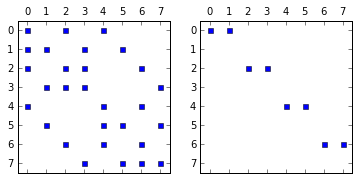

In [17]:
dx, dy, dz = solver.mesh.width
dxyz = dx * dy * dz

inscatter = solver.mgxs_lib['START']['nu-scatter matrix'].get_mean_matrix()
absorb = solver.mgxs_lib['START']['absorption'].get_mean_matrix()
chi_p = solver.mgxs_lib['START']['chi-prompt'].get_mean_matrix()
chi_d = solver.mgxs_lib['START']['chi-delayed'].get_mean_matrix()
nu_fis_p = solver.mgxs_lib['START']['prompt-nu-fission'].get_mean_matrix()
nu_fis_d = solver.mgxs_lib['START']['delayed-nu-fission'].get_mean_matrix()
stream, stream_corr = solver.compute_surface_dif_coefs('START')
flux = solver.mgxs_lib['START']['absorption'].tallies['flux'].get_values()
outscatter = sps.diags(np.asarray(inscatter.sum(axis=0)).flatten(), 0)

if isinstance(nu_fis_d, list):
    nu_fis_d = sum(nu_fis_d)

# Form the A and M matrices                                                                                                                                                          
loss_matrix = dxyz * (absorb + outscatter - inscatter) + stream + stream_corr
prod_matrix = dxyz * (chi_p * nu_fis_p + chi_d * nu_fis_d)
flux = flux.flatten()

fig = plt.figure()
plt.subplot(1,2,1)
plt.spy(loss_matrix, markersize=5)
plt.subplot(1,2,2)
plt.spy(prod_matrix, markersize=5)

Now, we want to form the streaming operator. In order to do this, we need to compute the surface diffusion coefficient coefficients. Below is the plot of the surface diffusion coefficients for our 2x2 mesh with 2 energy groups:

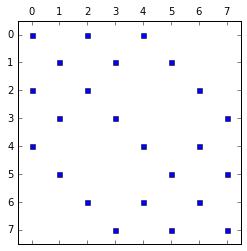

In [18]:
sdc_matrix, sdc_corr_matrix = solver.compute_surface_dif_coefs('START')

fig = plt.figure()
plt.spy(sdc_corr_matrix, markersize=5)

In order to maintain balance between our diffusion and transport solves, we need to compute the surface diffusion coefficient correction terms. This is achieved by tallying the currents between coarse mesh cells and computing the correction terms such that the current between mesh cells is preserved.

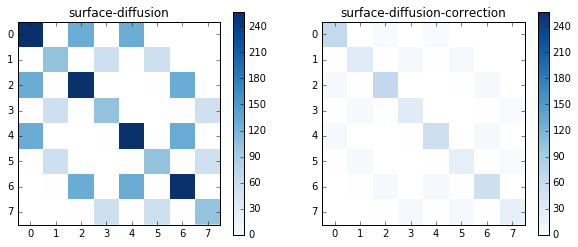

In [19]:
import scipy.sparse as sps

# Get matrices for all the other important cross sections
matrices = {}
matrices['surface-diffusion'], matrices['surface-diffusion-correction'] = solver.compute_surface_dif_coefs('START')
for key,mgxs in solver.mgxs_lib['START'].items():
    if key != 'current':
        matrices[key] = mgxs.get_mean_matrix()

fig = plt.figure(figsize=(10,4))
xs = 'surface-diffusion'
matrix = np.abs(matrices[xs].todense())
vmin = matrix.min()
vmax = matrix.max()
matrix[matrix == 0.] = np.nan
plt.subplot(1,2,1)
plt.imshow(matrix, interpolation='none', cmap='Blues', vmin=vmin, vmax=vmax)
plt.title(xs)
plt.colorbar()

xs = 'surface-diffusion-correction'
matrix = np.abs(matrices[xs].todense())
matrix[matrix == 0.] = np.nan
plt.subplot(1,2,2)
plt.imshow(matrix, interpolation='none', cmap='Blues', vmin=vmin, vmax=vmax)
plt.title(xs)
plt.colorbar()

## Extracting and Storing MGXS Data

Let's first inspect our delayed-nu-fission section by printing it to the screen after condensing the cross section down to one group.

In [20]:
solver.mgxs_lib['START']['diffusion-coefficient'].get_condensed_xs(energy_groups).get_xs()

array([[ 1.27353933,  0.51740358],
       [ 1.27603657,  0.5115101 ],
       [ 1.28626128,  0.51027817],
       [ 1.28804747,  0.51040921]])

Since the `openmc.mgxs` module uses [tally arithmetic](https://mit-crpg.github.io/openmc/pythonapi/examples/tally-arithmetic.html) under-the-hood, the cross section is stored as a "derived" `Tally` object. This means that it can be queried and manipulated using all of the same methods supported for the `Tally` class in the OpenMC Python API. For example, we can construct a [Pandas](http://pandas.pydata.org/) `DataFrame` of the multi-group cross section data.

In [21]:
df = solver.mgxs_lib['START']['current'].get_pandas_dataframe()
df.head(12)

mesh 1       group in    surface nuclide     mean std. dev.
        x  y  z                                               
1       1  1  1        1  x-max out   total  0.00976  0.000644
3       1  1  1        1  y-max out   total  0.00504  0.000481
5       1  1  1        1  z-max out   total  0.00000  0.000000
7       1  1  1        1   x-max in   total  0.01092  0.000603
9       1  1  1        1   y-max in   total  0.00480  0.000432
11      1  1  1        1   z-max in   total  0.00000  0.000000
13      1  1  1        1  x-max out   total  0.03148  0.001286
15      1  1  1        1  y-max out   total  0.01508  0.001143
17      1  1  1        1  z-max out   total  0.00000  0.000000
19      1  1  1        1   x-max in   total  0.03480  0.001450
21      1  1  1        1   y-max in   total  0.01572  0.001166
23      1  1  1        1   z-max in   total  0.00000  0.000000

In [22]:
solver.mgxs_lib['START']['current'].get_xs()

array([[[ 0.00292,  0.03148,  0.     ,  0.01508,  0.     ,  0.     ,
          0.     ,  0.0348 ,  0.     ,  0.01572,  0.     ,  0.     ],
        [ 0.00052,  0.00976,  0.     ,  0.00504,  0.     ,  0.     ,
          0.     ,  0.01092,  0.     ,  0.0048 ,  0.     ,  0.     ]],

       [[ 0.0348 ,  0.     ,  0.     ,  0.0426 ,  0.     ,  0.     ,
          0.03148,  0.     ,  0.     ,  0.04212,  0.     ,  0.     ],
        [ 0.01092,  0.     ,  0.     ,  0.01396,  0.     ,  0.     ,
          0.00976,  0.     ,  0.     ,  0.01356,  0.     ,  0.     ]],

       [[ 0.00272,  0.02884,  0.01572,  0.     ,  0.     ,  0.     ,
          0.     ,  0.03252,  0.01508,  0.     ,  0.     ,  0.     ],
        [ 0.00068,  0.01168,  0.0048 ,  0.     ,  0.     ,  0.     ,
          0.     ,  0.01148,  0.00504,  0.     ,  0.     ,  0.     ]],

       [[ 0.03252,  0.     ,  0.04212,  0.     ,  0.     ,  0.     ,
          0.02884,  0.     ,  0.0426 ,  0.     ,  0.     ,  0.     ],
        [ 0.01148,  0

Each multi-group cross section object can be easily exported to a variety of file formats, including CSV, Excel, and LaTeX for storage or data processing.

## Using Tally Arithmetic to Compute the Delayed Neutron Precursor Concentrations

Finally, we illustrate how one can leverage OpenMC's [tally arithmetic](https://mit-crpg.github.io/openmc/pythonapi/examples/tally-arithmetic.html) data processing feature with `MGXS` objects. The `openmc.mgxs` module uses tally arithmetic to compute multi-group cross sections with automated uncertainty propagation. Each `MGXS` object includes an `xs_tally` attribute which is a "derived" `Tally` based on the tallies needed to compute the cross section type of interest. These derived tallies can be used in subsequent tally arithmetic operations. For example, we can use tally artithmetic to compute the delayed neutron precursor concentrations using the `Beta`, `DelayedNuFissionXS`, and `DecayRate` objects. The delayed neutron precursor concentrations are modeled using the following equations:

$$\frac{\partial}{\partial t} C_{k,d} (t) = \int_{0}^{\infty}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r} \nu_d \sigma_{f,x}(\mathbf{r},E',t)\Phi(\mathbf{r},E',t) - \lambda_{d} C_{k,d} (t) $$

$$C_{k,d} (t=0) = \frac{1}{\lambda_{d}} \int_{0}^{\infty}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r} \nu_d \sigma_{f,x}(\mathbf{r},E',t=0)\Phi(\mathbf{r},E',t=0) $$

First, let's investigate the decay rates. The fraction of the delayed neutron precursors remaining as a function of time after fission for each delayed group have been plotted below.

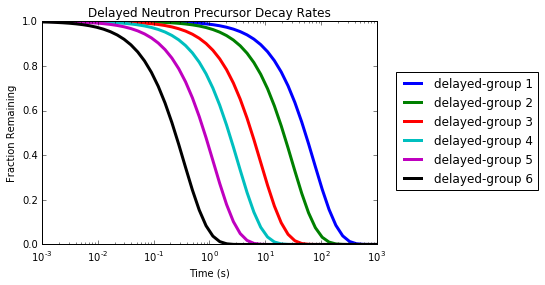

In [23]:
# Get the decay rate data
dr_tally = solver.mgxs_lib['START']['decay-rate'].xs_tally
dr = dr_tally.get_values().flatten()

# Compute the exponential decay of the precursors
time = np.logspace(-3,3)
dr_points = np.exp(-np.outer(dr, time))

# Create a plot of the fraction of the precursors remaining as a f(time)
colors = ['b', 'g', 'r', 'c', 'm', 'k']
for g,c in enumerate(colors):
    plt.semilogx(time, dr_points[g,:], color=c, linestyle='-', linewidth=3)

plt.title('Delayed Neutron Precursor Decay Rates')
plt.xlabel('Time (s)')
plt.ylabel('Fraction Remaining')
plt.legend(['delayed-group 1', 'delayed-group 2', 'delayed-group 3', 'delayed-group 4',
            'delayed-group 5', 'delayed-group 6'], loc=1, bbox_to_anchor=(1.5, 0.8))

In [24]:
# Create a tally object with only the delayed group filter for the time constants
delayed_nu_fission = solver.mgxs_lib['START']['delayed-nu-fission']
decay_rate = solver.mgxs_lib['START']['decay-rate']

# Use tally arithmetic to compute the precursor concentrations
precursor_conc = delayed_nu_fission.get_condensed_xs(one_group).tallies['delayed-nu-fission'].summation(filter_type='energy', remove_filter=True) / \
    decay_rate.xs_tally.summation(filter_type='energy', remove_filter=True) / solver.k_crit

# The difference is a derived tally which can generate Pandas DataFrames for inspection
precursor_conc.get_pandas_dataframe()

mesh 1       delayedgroup nuclide  \
        x  y  z                        
0       1  1  1            1   total   
1       1  1  1            2   total   
2       1  1  1            3   total   
3       1  1  1            4   total   
4       1  1  1            5   total   
5       1  1  1            6   total   
6       1  2  1            1   total   
7       1  2  1            2   total   
8       1  2  1            3   total   
9       1  2  1            4   total   
10      1  2  1            5   total   
11      1  2  1            6   total   
12      2  1  1            1   total   
13      2  1  1            2   total   
14      2  1  1            3   total   
15      2  1  1            4   total   
16      2  1  1            5   total   
17      2  1  1            6   total   
18      2  2  1            1   total   
19      2  2  1            2   total   
20      2  2  1            3   total   
21      2  2  1            4   total   
22      2  2  1            5   total   
23      2  2  1            6   total   

                                                score     mean std. dev.  
                                                                          
0   (delayed-nu-fission / (decay-rate / delayed-nu... 1.66e-03  2.35e-03  
1   (delayed-nu-fission / (decay-rate / delayed-nu... 3.82e-03  2.99e-03  
2   (delayed-nu-fission / (decay-rate / delayed-nu... 9.74e-04  9.54e-04  
3   (delayed-nu-fission / (decay-rate / delayed-nu... 8.68e-04  3.97e-04  
4   (delayed-nu-fission / (decay-rate / delayed-nu... 1.49e-04  1.17e-04  
5   (delayed-nu-fission / (decay-rate / delayed-nu... 1.77e-05  1.73e-05  
6   (delayed-nu-fission / (decay-rate / delayed-nu... 4.83e-03  6.84e-03  
7   (delayed-nu-fission / (decay-rate / delayed-nu... 1.15e-02  4.84e-03  
8   (delayed-nu-fission / (decay-rate / delayed-nu... 2.82e-03  1.63e-03  
9   (delayed-nu-fission / (decay-rate / delayed-nu... 2.55e-03  7.70e-04  
10  (delayed-nu-fission / (decay-rate / delayed-nu... 4.22e-04  1.91e-04  
11  (delayed-nu-fission / (decay-rate / delayed-nu... 4.97e-05  3.07e-05  
12  (delayed-nu-fission / (decay-rate / delayed-nu... 1.81e-03  2.56e-03  
13  (delayed-nu-fission / (decay-rate / delayed-nu... 4.16e-03  4.08e-03  
14  (delayed-nu-fission / (decay-rate / delayed-nu... 1.06e-03  1.04e-03  
15  (delayed-nu-fission / (decay-rate / delayed-nu... 9.82e-04  6.94e-04  
16  (delayed-nu-fission / (decay-rate / delayed-nu... 1.63e-04  1.28e-04  
17  (delayed-nu-fission / (decay-rate / delayed-nu... 1.94e-05  2.75e-05  
18  (delayed-nu-fission / (decay-rate / delayed-nu... 4.56e-03  4.46e-03  
19  (delayed-nu-fission / (decay-rate / delayed-nu... 1.08e-02  5.40e-03  
20  (delayed-nu-fission / (decay-rate / delayed-nu... 2.69e-03  1.37e-03  
21  (delayed-nu-fission / (decay-rate / delayed-nu... 2.37e-03  9.19e-04  
22  (delayed-nu-fission / (decay-rate / delayed-nu... 3.97e-04  2.63e-04  
23  (delayed-nu-fission / (decay-rate / delayed-nu... 4.66e-05  3.65e-05